#Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow==1.3.0

#Utils

In [3]:
import os
import matplotlib.pyplot as plt

def plot_and_save_fig(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 1, label='AUC = %0.4f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw = 1, linestyle='--')
    plt.legend(loc='lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ion()
    plt.savefig('./fig/AUROC')
    plt.pause(2)
    plt.close()

def load_checkpoint(g_path, d_path):
    
    generator = models.autoencoder()
    discriminator = models.FCNN()

    g_checkpoint = torch.load(g_path)
    d_checkpoint = torch.load(d_path)

    g_optimizer = torch.optim.Adam(generator.parameters(), lr = 0.0002, weight_decay = 1e-3)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, weight_decay = 1e-3)

    g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dict'])
    d_optimizer.load_state_dict(d_checkpoint['optimizer_state_dict'])

    generator.load_state_dict(g_checkpoint['model_state_dict'])
    discriminator.load_state_dict(d_checkpoint['model_state_dict'])

    assert g_checkpoint['epoch'] == d_checkpoint['epoch'], 'epoch number loading error'
    current_epoch = g_checkpoint['epoch']

    return generator, discriminator, g_optimizer, d_optimizer, current_epoch

def get_MCC(TP, FP, FN, TN):
    try:
        MCC = ( TP * TN - FP * FN) / (((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** (0.5))
        MCC = round(MCC, 4)
    except:
        MCC = 0
    return MCC

def get_accuracy(TP, FP, FN, TN):
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    accuracy = round(accuracy, 4)
    return accuracy

def get_recall(TP, FP, FN, TN):
    try:
        recall = TP / (TP + FN)
        recall = round(recall, 4)
    except:
        recall = 'N/A'
    return recall

def get_precision(TP, FP, FN, TN):
    try:
        precision = TP / (TP + FP)
        precision = round(precision, 4)
    except:
        precision = 'N/A'
    return precision

def get_F1_score(TP, FP, FN, TN):
    try:
        recall = get_recall(TP = TP, FP = FP, FN = FN, TN = TN)
        precision = get_precision(TP = TP, FP = FP, FN = FN, TN = TN)
        F1_score = 2 / ((1 / recall) + (1 / precision))
        F1_score = round(F1_score, 4)
    except:
        F1_score = 'N/A'
    return F1_score

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt

tf.set_random_seed(
    4
)

np.random.seed(0)


def one_hot(x, depth):
    x_one_hot = np.zeros((len(x), depth), dtype=np.int32)
    x = x.astype(int)
    for i in range(x_one_hot.shape[0]):
        x_one_hot[i, x[i]] = 1
    return x_one_hot


def xavier_init(size): # initialize the weight-matrix W.
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def sample_Z(m, n):   # generating the input for G.
    return np.random.uniform(-1., 1., size=[m, n])


def sample_shuffle_spv(X, labels):
	n_samples = len(X)
	s = np.arange(n_samples)
	np.random.shuffle(s)
	return np.array(X[s]), labels[s]


def sample_shuffle_uspv(X):
	n_samples = len(X)
	s = np.arange(n_samples)
	np.random.shuffle(s)
	return np.array(X[s])


def kde_density_estimator(X,kernel='gaussian',bandwidth=0.2):
   return KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X)

def complement_density(kde, X, sf=0.5):
    # probs = map(lambda x: np.exp(kde.score([x])), X)
    probs = np.exp(kde.score_samples(X))
    thrld = np.median(probs)
    return np.array(
        map(lambda x: low_density(x, thrld, sf), probs)
    )

def low_density(prob, thrld, sf):

    if prob > thrld:
        return sf * np.reciprocal(prob)
        # return sf * (1-prob)
    else:
        return thrld



def pull_away_loss(g):

    Nor = tf.norm(g, axis=1)
    Nor_mat = tf.tile(tf.expand_dims(Nor, axis=1),
                      [1, tf.shape(g)[1]])
    X = tf.divide(g, Nor_mat)
    X_X = tf.square(tf.matmul(X, tf.transpose(X)))
    mask = tf.subtract(tf.ones_like(X_X),
                       tf.diag(
                           tf.ones([tf.shape(X_X)[0]]))
                       )
    pt_loss = tf.divide(tf.reduce_sum(tf.multiply(X_X, mask)),
                        tf.multiply(
                            tf.cast(tf.shape(X_X)[0], tf.float32),
                            tf.cast(tf.shape(X_X)[0]-1, tf.float32)))

    return pt_loss


def draw_trend(D_real_prob, D_fake_prob, D_val_prob, fm_loss, f1):

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(311)
    p1, = plt.plot(D_real_prob, "-g")
    p2, = plt.plot(D_fake_prob, "--r")
    p3, = plt.plot(D_val_prob, ":c")
    plt.xlabel("# of epoch")
    plt.ylabel("probability")
    leg = plt.legend([p1, p2, p3], [r'$p(y|V_B)$', r'$p(y|\~{V})$', r'$p(y|V_M)$'], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.draw_frame(False)
    # plt.legend(frameon=False)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(312)
    p4, = plt.plot(fm_loss, "-b")
    plt.xlabel("# of epoch")
    plt.ylabel("feature matching loss")
    # plt.legend([p4], ["d_real_prob", "d_fake_prob", "d_val_prob"], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(313)
    p5, = plt.plot(f1, "-y")
    plt.xlabel("# of epoch")
    plt.ylabel("F1")
    # plt.legend([p1, p2, p3, p4, p5], ["d_real_prob", "d_fake_prob", "d_val_prob", "fm_loss","f1"], loc=1, bbox_to_anchor=(1, 3.5), borderaxespad=0.)
    plt.show()


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


#OCAN

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import sys

In [6]:

# TODO
mb_size = 15
dim_input = 28

D_dim = [dim_input, 100, 50, 2]
G_dim = [50, 100, dim_input]
Z_dim = G_dim[0]

# define placeholders for labeled-data, unlabeled-data, noise-data and target-data.

X_oc = tf.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input])

# declare weights and biases of discriminator.

D_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
D_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

D_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
D_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

D_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
D_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

G_W1 = tf.Variable(xavier_init([G_dim[0], G_dim[1]]))
G_b1 = tf.Variable(tf.zeros(shape=[G_dim[1]]))

G_W2 = tf.Variable(xavier_init([G_dim[1], G_dim[2]]))
G_b2 = tf.Variable(tf.zeros(shape=[G_dim[2]]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

# declare weights and biases of pre-train net for density estimation.

T_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
T_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

T_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
T_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

T_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
T_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_T = [T_W1, T_W2, T_W3, T_b1, T_b2, T_b3]

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.nn.tanh(tf.matmul(G_h1, G_W2) + G_b2)
    return G_logit


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.softmax(D_logit)
    return D_prob, D_logit, D_h2


# pre-train net for density estimation.

def discriminator_tar(x):
    T_h1 = tf.nn.relu(tf.matmul(x, T_W1) + T_b1)
    T_h2 = tf.nn.relu(tf.matmul(T_h1, T_W2) + T_b2)
    T_logit = tf.matmul(T_h2, T_W3) + T_b3
    T_prob = tf.nn.softmax(T_logit)
    return T_prob, T_logit, T_h2

D_prob_real, D_logit_real, D_h2_real = discriminator(X_oc)

G_sample = generator(Z)
D_prob_gen, D_logit_gen, D_h2_gen = discriminator(G_sample)

D_prob_tar, D_logit_tar, D_h2_tar = discriminator_tar(X_tar)
D_prob_tar_gen, D_logit_tar_gen, D_h2_tar_gen = discriminator_tar(G_sample)
# D_prob_val, _, D_h1_val = discriminator(X_val)

# disc. loss
y_real= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
y_gen = tf.placeholder(tf.int32, shape=[None, D_dim[3]])

D_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=D_logit_real,labels=y_real))
D_loss_gen = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=D_logit_gen, labels=y_gen))

ent_real_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_real, tf.log(D_prob_real)), 1
                        )
                    )

ent_gen_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_gen, tf.log(D_prob_gen)), 1
                        )
                    )

D_loss = D_loss_real + D_loss_gen + 1.85 * ent_real_loss

# gene. loss
pt_loss = pull_away_loss(D_h2_tar_gen)

y_tar= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
T_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=D_logit_tar, labels=y_tar))
tar_thrld = tf.divide(tf.reduce_max(D_prob_tar_gen[:,-1]) +
                      tf.reduce_min(D_prob_tar_gen[:,-1]), 2)

# tar_thrld = tf.reduce_mean(D_prob_tar_gen[:,-1])

indicator = tf.sign(
              tf.subtract(D_prob_tar_gen[:,-1],
                          tar_thrld))
condition = tf.greater(tf.zeros_like(indicator), indicator)
mask_tar = tf.where(condition, tf.zeros_like(indicator), indicator)
G_ent_loss = tf.reduce_mean(tf.multiply(tf.log(D_prob_tar_gen[:,-1]), mask_tar))
# G_ent_loss = tf.reduce_mean(tf.log(D_prob_tar_gen[:,-1]))

fm_loss = tf.reduce_mean(
            tf.sqrt(
                tf.reduce_sum(
                    tf.square(D_logit_real - D_logit_gen), 1
                    )
                )
            )

G_loss = pt_loss + G_ent_loss + fm_loss

D_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
T_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(T_loss, var_list=theta_T)

#Loading Data

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()


# train_data = pd.read_csv("trainData.csv", header = None).values
# test_data = pd.read_csv("testData.csv", header = None).values

data = pd.read_csv("./drive/MyDrive/TAAI/creditcard.csv").values.tolist()

x_vandal = []
x_benign = []

for row in data:
  if int(row[-1]) == 1:
    x_vandal.append(row[1:-2])
  else:
    x_benign.append(row[1:-2])

x_benign = min_max_scaler.fit_transform(np.array(x_benign))
x_vandal = min_max_scaler.transform(np.array(x_vandal))

x_benign = sample_shuffle_uspv(x_benign)
x_vandal = sample_shuffle_uspv(x_vandal)

x_pre = x_benign[0:700]
y_pre = np.zeros(len(x_pre))
y_pre = one_hot(y_pre, 2)

x_train = x_pre

y_real_mb = one_hot(np.zeros(mb_size),2)
y_fake_mb = one_hot(np.ones(mb_size),2)

x_test = x_benign[-490:].tolist() + x_vandal[-490:].tolist()
x_test = np.array(x_test)

y_test = np.zeros(len(x_test))
y_test[490:] = 1

# print(x_train)
# print(x_test)
# print(y_test)


#Training

accuracy: 0.5367, recall: 1.0, precision: 0.0735, F1_score: 0.1369, MCC: 0.1953
              precision    recall  f1-score   support

      benign     0.5191    1.0000    0.6834       490
      vandal     1.0000    0.0735    0.1369       490

   micro avg     0.5367    0.5367    0.5367       980
   macro avg     0.7595    0.5367    0.4101       980
weighted avg     0.7595    0.5367    0.4101       980

accuracy: 0.5, recall: N/A, precision: 0.0, F1_score: N/A, MCC: 0
              precision    recall  f1-score   support

      benign     0.5000    1.0000    0.6667       490
      vandal     0.0000    0.0000    0.0000       490

   micro avg     0.5000    0.5000    0.5000       980
   macro avg     0.2500    0.5000    0.3333       980
weighted avg     0.2500    0.5000    0.3333       980



/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy: 0.5061, recall: 1.0, precision: 0.0122, F1_score: 0.0241, MCC: 0.0785
              precision    recall  f1-score   support

      benign     0.5031    1.0000    0.6694       490
      vandal     1.0000    0.0122    0.0242       490

   micro avg     0.5061    0.5061    0.5061       980
   macro avg     0.7515    0.5061    0.3468       980
weighted avg     0.7515    0.5061    0.3468       980

accuracy: 0.5816, recall: 0.9878, precision: 0.1653, F1_score: 0.2832, MCC: 0.2948
              precision    recall  f1-score   support

      benign     0.5445    0.9980    0.7046       490
      vandal     0.9878    0.1653    0.2832       490

   micro avg     0.5816    0.5816    0.5816       980
   macro avg     0.7662    0.5816    0.4939       980
weighted avg     0.7662    0.5816    0.4939       980

accuracy: 0.5878, recall: 0.9886, precision: 0.1776, F1_score: 0.3011, MCC: 0.307
              precision    recall  f1-score   support

      benign     0.5482    0.9980    0.7077   

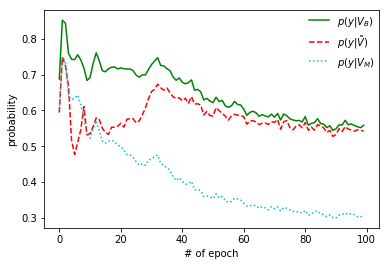

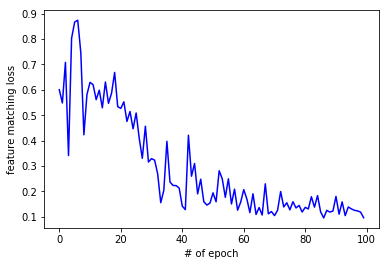

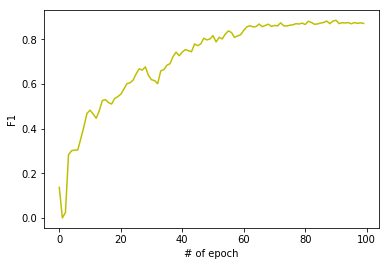

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

_ = sess.run(T_solver,
             feed_dict={
                X_tar:x_pre,
                y_tar:y_pre
                })

q = np.divide(len(x_train), mb_size)

d_ben_pro, d_fake_pro, fm_loss_coll = list(), list(), list()
f1_score  = list()
d_val_pro = list()

#TODO
n_round = 100

for n_epoch in range(n_round):

    X_mb_oc = sample_shuffle_uspv(x_train)

    for n_batch in range(q):

        _, D_loss_curr, ent_real_curr = sess.run([D_solver, D_loss, ent_real_loss],
                                          feed_dict={
                                                     X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                     Z: sample_Z(mb_size, Z_dim),
                                                     y_real: y_real_mb,
                                                     y_gen: y_fake_mb
                                                     })

        _, G_loss_curr, fm_loss_curr = sess.run([G_solver, G_loss, fm_loss],feed_dict={Z: sample_Z(mb_size, Z_dim), X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size]})
        # _, G_loss_curr, fm_loss_, kld_ = sess.run([G_solver, G_loss, fm_loss, pt_loss + G_ent_loss],
        

    D_prob_real_, D_prob_gen_ = sess.run([D_prob_real, D_prob_gen],
                                         feed_dict={X_oc: x_train,
                                                    Z: sample_Z(len(x_train), Z_dim)})

    #TODO
    
    D_prob_vandal_ = sess.run(D_prob_real,
                              #feed_dict={X_oc: x_vandal[0:7000]})
                              feed_dict={X_oc:x_vandal[-490:]}) 
    

    d_ben_pro.append(np.mean(D_prob_real_[:, 0]))
    d_fake_pro.append(np.mean(D_prob_gen_[:, 0]))
    d_val_pro.append(np.mean(D_prob_vandal_[:, 0]))
    fm_loss_coll.append(fm_loss_curr)

    prob, _ = sess.run([D_prob_real, D_logit_real], feed_dict={X_oc: x_test})
    y_pred = np.argmax(prob, axis=1)
    # print(y_pred)
    conf_mat = classification_report(y_test, y_pred, target_names=['benign', 'vandal'], digits=4)
    f1_score.append(float(filter(None, conf_mat.strip().split(" "))[12]))
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for x in zip(y_pred, y_test):
        if x[0] == x[1]:
            if x[1] == 0:
                TN+=1
            elif x[1] == 1:
                TP+=1
        else:
            if x[1] == 0:
                FN+=1
            elif x[1] == 1:
                FP+=1

    # print(TP, TN, FP, FN)
    accuracy = get_accuracy(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    recall = get_recall(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    precision = get_precision(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    F1_score = get_F1_score(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    MCC = get_MCC(TP = float(TP), FP = float(FP), FN = float(FN), TN = float(TN))
    print("accuracy: {}, recall: {}, precision: {}, F1_score: {}, MCC: {}".format(accuracy, recall, precision, F1_score, MCC))
    print conf_mat
    # print MCC

# if not dra_tra_pro:
acc = np.sum(y_pred == y_test)/float(len(y_pred))
print conf_mat
print "acc:%s"%acc

draw_trend(d_ben_pro, d_fake_pro, d_val_pro, fm_loss_coll, f1_score)